8-6 RNN을 이용한 텍스트 생성(Text Generation using RNN)\
다 대 일(many-to-one) 구조의 RNN을 사용하여 문맥을 반영해서 텍스트를 생성하는 모델을 만들어보자.

1. RNN을 이용하여 텍스트 생성하기 

ex) '경마장에 있는 말이 뛰고 있다' , '그의 말이 법이다', '가는 말이 고와야 오는 말이 곱다'\
모델이 문맥을 학습할 수 있도록 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성하면 아래와 같다.\
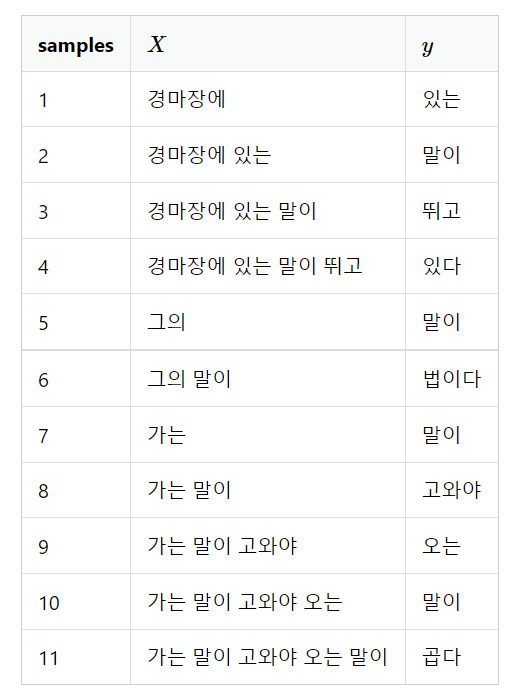

1) 데이터에 대한 이해와 처리

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

단어 집합의 크기를 저장할때는 케라스 토크나이저 정수 인코딩은 인덱스가 1부터 시작하지만, 패딩을 위한 0을 고려하여 +1 해준다.

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 12


In [4]:
print(tokenizer.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [5]:
sequences = list()
for line in text.split('\n') : # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(encoded)) : 
        sequence = encoded[:i+1]
        sequences.append(sequence)
        
print('학습에 사용할 샘플 개수 : %d' % len(sequences))

학습에 사용할 샘플 개수 : 11


In [6]:
print(sequences)

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


전체 훈련 데이터에 대해서 맨 우측에 있는 단어에 대해서만 레이블로 분리해야 한다. \
우선 샘플에 대해서 길이를 일치시켜 줘야한다. 가장 긴 샘플의 길이를 기준으로 한다.

In [7]:
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


In [8]:
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre') # 모든 샘플의 길이 6으로 패딩
sequences

array([[ 0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  2,  3,  1],
       [ 0,  0,  2,  3,  1,  4],
       [ 0,  2,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  6,  1,  7],
       [ 0,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  8,  1,  9],
       [ 0,  0,  8,  1,  9, 10],
       [ 0,  8,  1,  9, 10,  1],
       [ 8,  1,  9, 10,  1, 11]])

각 샘플의 마지막 단어를 레이블로 분리한다. 레이블의 분리는 numpy를 이용 \
리스트의 마지막 값을 제외하고 저장한 것은 X , 리스트의 마지막 값만 저장한 것은 y . 이는 레이블에 해당된다.

In [9]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [10]:
print(X)
print(y)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]
[ 3  1  4  5  1  7  1  9 10  1 11]


In [11]:
y = to_categorical(y, num_classes = vocab_size) # 원-핫 인코딩

In [12]:
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


2) 모델 설계하기

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 32이다. 전결합층을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계한다.\
해당 모델은 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델이므로 \
출력층에서 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 200 에포크를 수행한다.

In [14]:
embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 200, verbose = 2)

Epoch 1/200
1/1 - 2s - loss: 2.4499 - accuracy: 0.0909 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 2.4347 - accuracy: 0.2727 - 10ms/epoch - 10ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4190 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4027 - accuracy: 0.4545 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 2.3857 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 6/200
1/1 - 0s - loss: 2.3678 - accuracy: 0.3636 - 7ms/epoch - 7ms/step
Epoch 7/200
1/1 - 0s - loss: 2.3491 - accuracy: 0.3636 - 6ms/epoch - 6ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3295 - accuracy: 0.3636 - 6ms/epoch - 6ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3089 - accuracy: 0.3636 - 7ms/epoch - 7ms/step
Epoch 10/200
1/1 - 0s - loss: 2.2874 - accuracy: 0.3636 - 7ms/epoch - 7ms/step
Epoch 11/200
1/1 - 0s - loss: 2.2649 - accuracy: 0.3636 - 6ms/epoch - 6ms/step
Epoch 12/200
1/1 - 0s - loss: 2.2416 - accuracy: 0.3636 - 6ms/epoch - 6ms/step
Epoch 13/200
1/1 - 0s - loss: 2.2174 - accuracy: 0.3636 - 5ms

Epoch 105/200
1/1 - 0s - loss: 0.6958 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 106/200
1/1 - 0s - loss: 0.6851 - accuracy: 0.9091 - 7ms/epoch - 7ms/step
Epoch 107/200
1/1 - 0s - loss: 0.6747 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 108/200
1/1 - 0s - loss: 0.6644 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 109/200
1/1 - 0s - loss: 0.6542 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 110/200
1/1 - 0s - loss: 0.6442 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 111/200
1/1 - 0s - loss: 0.6344 - accuracy: 0.9091 - 9ms/epoch - 9ms/step
Epoch 112/200
1/1 - 0s - loss: 0.6246 - accuracy: 0.9091 - 5ms/epoch - 5ms/step
Epoch 113/200
1/1 - 0s - loss: 0.6150 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 114/200
1/1 - 0s - loss: 0.6056 - accuracy: 0.9091 - 6ms/epoch - 6ms/step
Epoch 115/200
1/1 - 0s - loss: 0.5962 - accuracy: 0.9091 - 9ms/epoch - 9ms/step
Epoch 116/200
1/1 - 0s - loss: 0.5870 - accuracy: 0.9091 - 5ms/epoch - 5ms/step
Epoch 117/200
1/1 - 0s - loss: 0.5779 - 

In [16]:
# 모델 성능 확인을 위한 문장을 생성하는 함수를 만들어서 출력
def sentence_generation(model, tokenizer, current_word, n) : # 모델, 토크나이저 , 현재단어, 반복할 횟수
    init_word = current_word
    sentence = ''
    
    # n번 반복
    for _ in range(n) :
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0] # 정수 인코딩
        encoded = pad_sequences([encoded], maxlen = 5, padding = 'pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장
        result = model.predict(encoded, verbose = 0)
        result = np.argmax(result, axis = 1)
        
        for word, index in tokenizer.word_index.items():
            # 만약 예측한 단어와 인덱스가 동일한 단어가 있다면 break
            if index == result :
                break
        
        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' ' + word
        
        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word
        
    sentence = init_word + sentence
    return sentence

In [17]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [18]:
print(sentence_generation(model, tokenizer, '경마장에', 3))

경마장에 있는 말이 뛰고


In [20]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [21]:
print(sentence_generation(model, tokenizer, '가는', 5))

가는 말이 고와야 오는 말이 곱다


In [22]:
print(sentence_generation(model, tokenizer, '가는', 8)) 
# 뒤의 단어는 학습하지 않아서 임의의 단어를 예측해서 집어넣는다.

가는 말이 고와야 오는 말이 곱다 경마장에 있다 있다


이 모델은 충분한 훈련 데이터를 갖고 있지 못하므로 위에서 문장의 길이에 맞게 적절하게 예측해야하는 횟수 4,2,5를 각각 인자값으로 주었다.\
이 이상의 숫자를 주면 다음 단어는 배운적이 없어 임의 예측을 한다.

2. LSTM을 이용하여 텍스트 생성하기

1) 데이터에 대한 이해와 전처리

In [23]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [24]:
df = pd.read_csv('ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [25]:
print(' 열의 개수 : ', len(df.columns))
print(df.columns)

 열의 개수 :  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [26]:
print(df['headline'].isnull().values.any()) # Null 값 확인

False


In [27]:
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values))
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [28]:
print('총 샘플의 개수 : {}'.format(len(headline)))

총 샘플의 개수 : 1324


In [29]:
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

노이즈값 제거 후 샘플의 개수 : 1214


In [30]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [31]:
# 데이터 전처리(여기서는 구두점 제거와 단어의 소문자화)
def repreprocessing(raw_sentence) :
    preprocessed_sentence = raw_sentence.encode("utf8").decode("ascii","ignore")
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preprocessed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


총 3494개의 단어가 존재, 정수 인코딩을 진행하는 동시에 하나의 문장을 여러 줄로 분해하여 훈련 데이터를 구성한다. \
ex) former nfl cheerleaders settlement offer 1 and a meeting with goodell 을\
1 - former nfl \
2 - former nfl cheerleaders 등으로

In [33]:
sequences = list()

for sentence in preprocessed_headline:
    
    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(encoded)) :
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

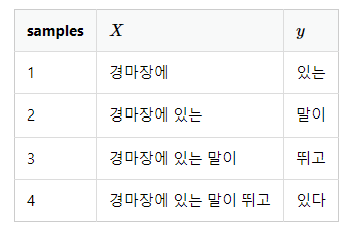\
ex) '경마장에 있는 말이 뛰고 있다' 일때, 하나의 단어를 예측하기 위해 이전에 등장한 단어들을 모두 참고하기 위해 하나의 문장을 나눈다

In [34]:
# 인덱스로부터 단어를 찾는 index_to_word를 만들자
index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key
    
print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


이제 y데이터를 분리하기 전에 전체 샘플의 길이를 동일하게 만드는 패딩 작업을 수행한다

In [35]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [36]:
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre')
print(sequences[:4])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   99  269  371 1115  582]]


In [37]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [60]:
print(X[:4])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   99  269  371 1115]]


In [40]:
y = to_categorical(y, num_classes=vocab_size) # 원-핫 인코딩

2) 모델 설계하기

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 128이다. 전결합층을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계 \
해당 모델은 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델이다. \
따라서 출력층에 소프트맥스 회귀를 사용해야하므로 활성화 함수로는 소프트맥스 함수, 손실 함수로 크로스 엔트로피 함수를 사용하여 200에포크를 수행

In [62]:
embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 6s - loss: 7.6412 - accuracy: 0.0274 - 6s/epoch - 23ms/step
Epoch 2/200
244/244 - 4s - loss: 7.1156 - accuracy: 0.0311 - 4s/epoch - 16ms/step
Epoch 3/200
244/244 - 4s - loss: 6.9734 - accuracy: 0.0384 - 4s/epoch - 16ms/step
Epoch 4/200
244/244 - 4s - loss: 6.8434 - accuracy: 0.0406 - 4s/epoch - 16ms/step
Epoch 5/200
244/244 - 4s - loss: 6.6959 - accuracy: 0.0437 - 4s/epoch - 17ms/step
Epoch 6/200
244/244 - 4s - loss: 6.5428 - accuracy: 0.0464 - 4s/epoch - 16ms/step
Epoch 7/200
244/244 - 4s - loss: 6.3787 - accuracy: 0.0500 - 4s/epoch - 17ms/step
Epoch 8/200
244/244 - 4s - loss: 6.1981 - accuracy: 0.0557 - 4s/epoch - 17ms/step
Epoch 9/200
244/244 - 4s - loss: 6.0168 - accuracy: 0.0584 - 4s/epoch - 17ms/step
Epoch 10/200
244/244 - 4s - loss: 5.8393 - accuracy: 0.0641 - 4s/epoch - 16ms/step
Epoch 11/200
244/244 - 4s - loss: 5.6711 - accuracy: 0.0705 - 4s/epoch - 16ms/step
Epoch 12/200
244/244 - 4s - loss: 5.5080 - accuracy: 0.0737 - 4s/epoch - 17ms/step
Epoch 13/200


Epoch 100/200
244/244 - 4s - loss: 0.7051 - accuracy: 0.8621 - 4s/epoch - 16ms/step
Epoch 101/200
244/244 - 4s - loss: 0.6903 - accuracy: 0.8654 - 4s/epoch - 16ms/step
Epoch 102/200
244/244 - 4s - loss: 0.6738 - accuracy: 0.8668 - 4s/epoch - 16ms/step
Epoch 103/200
244/244 - 4s - loss: 0.6605 - accuracy: 0.8695 - 4s/epoch - 16ms/step
Epoch 104/200
244/244 - 4s - loss: 0.6460 - accuracy: 0.8722 - 4s/epoch - 16ms/step
Epoch 105/200
244/244 - 4s - loss: 0.6325 - accuracy: 0.8736 - 4s/epoch - 16ms/step
Epoch 106/200
244/244 - 4s - loss: 0.6173 - accuracy: 0.8777 - 4s/epoch - 16ms/step
Epoch 107/200
244/244 - 4s - loss: 0.6057 - accuracy: 0.8794 - 4s/epoch - 16ms/step
Epoch 108/200
244/244 - 4s - loss: 0.5917 - accuracy: 0.8821 - 4s/epoch - 16ms/step
Epoch 109/200
244/244 - 4s - loss: 0.5790 - accuracy: 0.8835 - 4s/epoch - 16ms/step
Epoch 110/200
244/244 - 4s - loss: 0.5659 - accuracy: 0.8865 - 4s/epoch - 16ms/step
Epoch 111/200
244/244 - 4s - loss: 0.5552 - accuracy: 0.8875 - 4s/epoch - 16

Epoch 198/200
244/244 - 4s - loss: 0.2666 - accuracy: 0.9157 - 4s/epoch - 16ms/step
Epoch 199/200
244/244 - 4s - loss: 0.2706 - accuracy: 0.9140 - 4s/epoch - 16ms/step
Epoch 200/200
244/244 - 4s - loss: 0.2668 - accuracy: 0.9161 - 4s/epoch - 16ms/step


In [63]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장
        result = model.predict(encoded, verbose = 0)
        result = np.argmax(result, axis = 1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [64]:
print(sentence_generation(model, tokenizer, 'i', 10))

i want to be rich and im not sorry have at


In [65]:
print(sentence_generation(model, tokenizer, 'how', 10))

how to make a crossword puzzle love to chill trump vs


In [67]:
print(sentence_generation(model, tokenizer, 'maybe', 20))

maybe the open eras forgotten home still cold and wet in the earliest house in the leadership in be up become


책 내용이랑 실습코드랑 좀 다른듯함